In [83]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

In [84]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data)
n = len(iris.target)

In [85]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [86]:
iris_df['target'] = iris.target

In [87]:
iris_df.head()

,0,1,2,3,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [88]:
iris_df.rename(columns = {0: 'sepal_length', 1: 'sepal_width', 2: 'petal_length', 3: 'petal_width'}, inplace = True)

In [89]:
def sampling(data, n, random_state):
    synth_data = pd.DataFrame()
    i = 0
    for column in data.columns:
        synth_data[column] = data[column].sample(n = n, replace = True, random_state = random_state + i * 10).reset_index(drop = True)
        i += 1
    return synth_data

In [90]:
synth_df = sampling(iris_df, n, 30025)

In [91]:
synth_df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,6.4,3.1,1.4,1.5,1
1,7.2,3.6,1.4,0.4,1
2,4.4,2.9,5.7,0.4,0
3,6.4,3.0,4.1,1.8,0
4,5.0,2.9,3.7,0.2,1


In [92]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse = False)
iris_targets_enc = enc.fit_transform(np.reshape(iris.target, (n, 1)))
synth_targets_enc = enc.fit_transform(synth_df[['target']])

In [93]:
iris_df[['setosa', 'versicolor', 'virginica']] = iris_targets_enc
iris_df.drop(['target'], axis = 1, inplace = True)
synth_df[['setosa', 'versicolor', 'virginica']] = synth_targets_enc
synth_df.drop(['target'], axis = 1, inplace = True)

In [94]:
iris_df['label'] = 1
synth_df['label'] = 0
X = pd.concat((iris_df, synth_df))

In [95]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

In [96]:
X.iloc[:, :-1].head()

,sepal_length,sepal_width,petal_length,petal_width,setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,1.0,0.0,0.0
1,4.9,3.0,1.4,0.2,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,1.0,0.0,0.0


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1], X.iloc[:, -1], test_size = 0.3, random_state = 30025)

In [98]:
import xgboost as xgb

In [99]:
xg_clf = xgb.XGBClassifier()

In [100]:
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [101]:
preds = xg_clf.predict(X_test)

In [102]:
np.sum(preds == y_test)/len(y_test)

0.8888888888888888

In [103]:
individual_preds = []
for tree_ in xg_clf.get_booster():
    individual_preds.append(
        tree_.predict(xgb.DMatrix(X_train))
    )

In [104]:
from scipy.special import expit as sigmoid, logit as inverse_sigmoid
individual_preds = np.vstack(individual_preds)
indivudual_logits = inverse_sigmoid(individual_preds)
final_logits = indivudual_logits.sum(axis=0)
final_preds = sigmoid(final_logits)

In [105]:
test = xg_clf.get_booster()

In [106]:
leaves = test.predict(xgb.DMatrix(X_train), pred_leaf = True)

In [107]:
leaves.shape

(210, 100)

In [108]:
leaves

array([[19., 15.,  4., ...,  6.,  2.,  5.],
       [23., 24., 12., ...,  5.,  5.,  6.],
       [20., 24., 27., ...,  7.,  6.,  4.],
       ...,
       [20., 13.,  5., ...,  1.,  6.,  4.],
       [ 9., 24., 27., ...,  8.,  2.,  4.],
       [23., 24., 27., ...,  6.,  2.,  6.]], dtype=float32)

In [109]:
from sklearn.neighbors import KernelDensity

In [110]:
#determining where each datapoint falls in which leaf of each tree
allocations = [{} for i in range(leaves.shape[1])]
for i in range(leaves.shape[0]):
    for j in range(leaves.shape[1]):
        if y_train.iloc[i] == 1:
            if leaves[i][j] not in allocations[j].keys():
                allocations[j][leaves[i][j]] = [i]
            else:
                allocations[j][leaves[i][j]].append(i)

In [111]:
densities = [[] for i in range(leaves.shape[1])]
probabilities = [[] for i in range(leaves.shape[1])]
n = sum(y_train)
for i in range(leaves.shape[1]):
    for key in allocations[i].keys():
        probabilities[i].append(len(allocations[i][key])/n)
        leaf_data = X_train.iloc[allocations[i][key]]
        densities[i].append(KernelDensity(kernel='gaussian').fit(leaf_data))

In [112]:
np.random.choice(densities[1], p = probabilities[1])

KernelDensity()

In [113]:
# Sampling procedure
sample_size = 300
forest_size = 100
samples = []
for i in range(sample_size):
    b = np.random.choice(forest_size)
    l = np.random.choice(densities[b], p = probabilities[b])
    samples.append(l.sample())
len(samples)

300

In [114]:
y_train.iloc[1]

1

In [115]:
smiley = pd.read_csv('smiley.csv', index_col = 0)
smiley.columns = ['x', 'y', 'classes']

In [116]:
import plotly.express as px

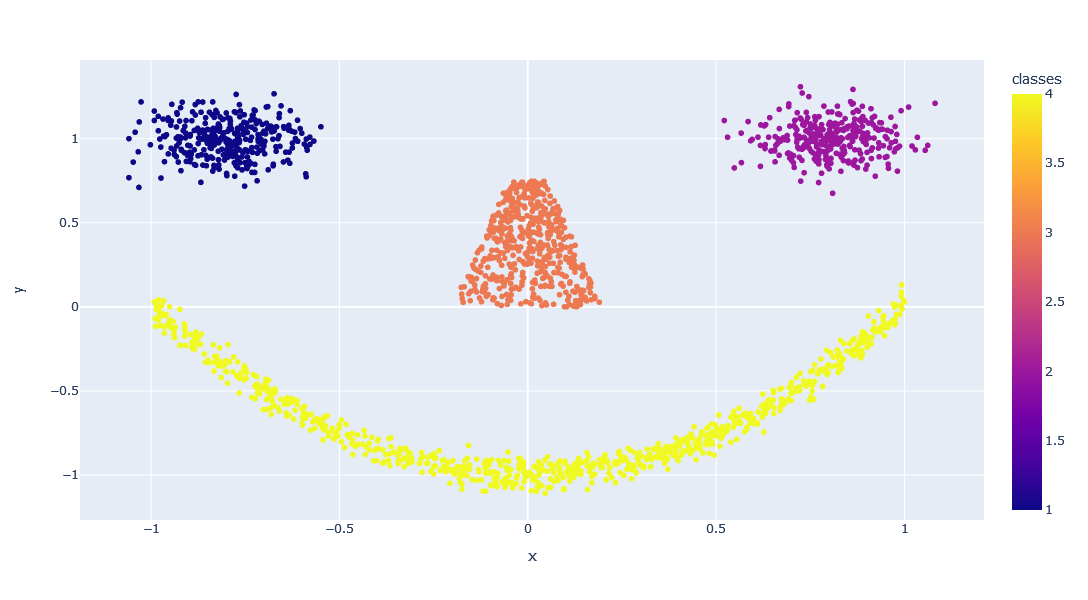

In [117]:
fig = px.scatter(smiley, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [118]:
synth_smiley = sampling(smiley, 2000, 30025)

In [119]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse = False)
smiley_targets_enc = enc.fit_transform(smiley[['classes']])
enc = OneHotEncoder(sparse = False)
synths_targets_enc = enc.fit_transform(synth_smiley[['classes']])

In [120]:
smiley[['0', '1', '2', '3']] = smiley_targets_enc
smiley.drop(['classes'], axis = 1, inplace = True)
synth_smiley[['0', '1', '2', '3']] = synths_targets_enc
synth_smiley.drop(['classes'], axis = 1, inplace = True)

In [121]:
smiley['label'] = 1
synth_smiley['label'] = 0
X = pd.concat((smiley, synth_smiley))

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :-1], X.iloc[:, -1], test_size = 0.3, random_state = 30025)

In [134]:
model = xgb.XGBClassifier(random_state = 1)
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [135]:
preds = xg_clf.predict(X_test)

In [136]:
np.sum(preds == y_test)/len(y_test)

0.9325

In [137]:
xgbooster = xg_clf.get_booster()

In [140]:
leaves = xgbooster.predict(xgb.DMatrix(X_train), pred_leaf = True)

In [141]:
leaves.shape

(2800, 100)

In [142]:
from sklearn.neighbors import KernelDensity

In [143]:
#determining where each datapoint falls in which leaf of each tree
allocations = [{} for i in range(leaves.shape[1])]
for i in range(leaves.shape[0]):
    for j in range(leaves.shape[1]):
        if y_train.iloc[i] == 1:
            if leaves[i][j] not in allocations[j].keys():
                allocations[j][leaves[i][j]] = [i]
            else:
                allocations[j][leaves[i][j]].append(i)

In [152]:
densities = [[] for i in range(leaves.shape[1])]
probabilities = [[] for i in range(leaves.shape[1])]
multinomial = [[] for i in range(leaves.shape[1])]
simpler_densities = [[] for i in range(leaves.shape[1])]
n = sum(y_train)
for i in range(leaves.shape[1]):
    for key in allocations[i].keys():
        probabilities[i].append(len(allocations[i][key])/n)
        leaf_data = X_train.iloc[allocations[i][key]]
        leaf_size = len(leaf_data)
        multinomial[i].append([])
        densities[i].append([])
        simpler_densities[i].append(KernelDensity(kernel = 'gaussian', bandwidth = 0.01).fit(leaf_data.iloc[:, :2]))
        for j in range(4):
            index = str(j)
            if not leaf_data[leaf_data[index] == 1].empty:
                multinomial[i][-1].append(len(leaf_data[leaf_data[index] == 1])/leaf_size)
                densities[i][-1].append(KernelDensity(kernel='gaussian', bandwidth = 0.01).fit(leaf_data[leaf_data[index] == 1].iloc[:, :2]))
            else:
                multinomial[i][-1].append(0)
                densities[i][-1].append(0)

# Sampling procedure
sample_size = 2000
forest_size = 100
samples = []
samples_class = []
class_size = 4
for i in range(sample_size):
    b = np.random.choice(forest_size)
    l = np.random.choice(len(densities[b]), p = probabilities[b])
    m = np.random.choice(class_size, p = multinomial[b][l])
    sampler = densities[b][l][m]
    samples.append(sampler.sample())
    samples_class.append(m)
len(samples)

In [153]:
# alternative sampling routine
samples = []
sample_size = 2000
forest_size = 100
class_size = 4
samples_class = []
for i in range(sample_size):
    b = np.random.choice(forest_size)
    l = np.random.choice(len(simpler_densities[b]), p = probabilities[b])
    m = np.random.choice(class_size, p = multinomial[b][l])
    sampler = simpler_densities[b][l]
    samples.append(sampler.sample())
    samples_class.append(m)
len(samples)

2000

In [154]:
gen = pd.DataFrame(np.array(samples).reshape((2000, 2)))
gen['classes'] = samples_class
gen.columns = ['x', 'y', 'classes']

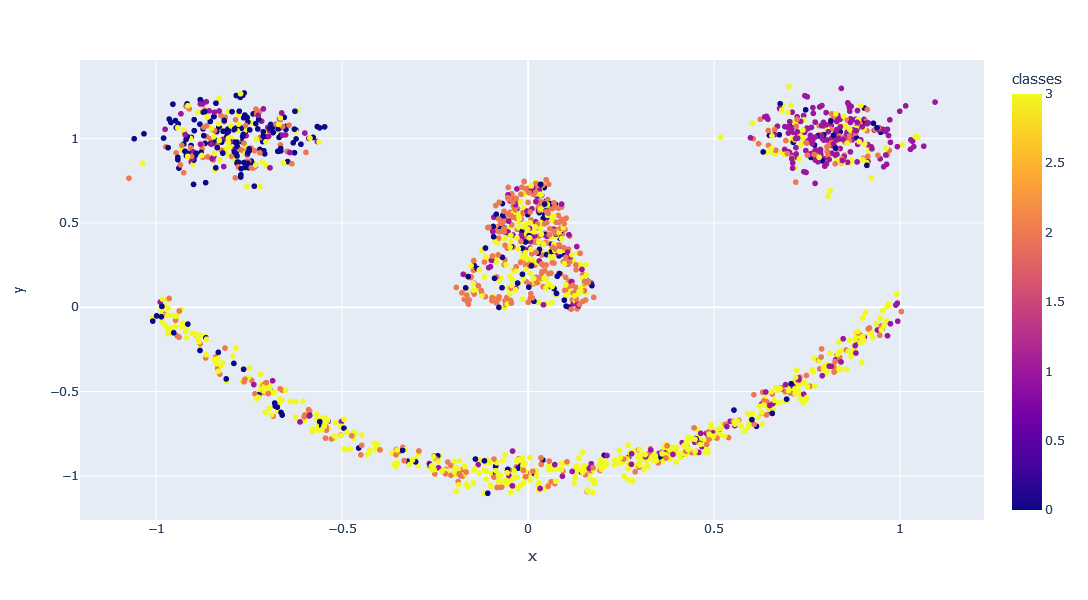

In [155]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [52]:
enc = OneHotEncoder(sparse = False)
gen_enc = enc.fit_transform(gen[['classes']])
gen[['0', '1', '2', '3']] = gen_enc
gen.drop(['classes'], axis = 1, inplace = True)
gen['label'] = 0

In [53]:
X2 = pd.concat((smiley, gen))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X2.iloc[:, :-1], X2.iloc[:, -1], test_size = 0.3, random_state = 30025)

In [55]:
model = xgb.XGBClassifier(random_state = 1)
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [56]:
preds = xg_clf.predict(X_test)

In [57]:
np.sum(preds == y_test)/len(y_test)

0.7708333333333334

In [58]:
xgbooster = xg_clf.get_booster()

In [59]:
leaves = xgbooster.predict(xgb.DMatrix(X_train), pred_leaf = True)

In [60]:
leaves.shape

(2800, 100)

In [61]:
from sklearn.neighbors import KernelDensity

In [62]:
#determining where each datapoint falls in which leaf of each tree
allocations = [{} for i in range(leaves.shape[1])]
for i in range(leaves.shape[0]):
    for j in range(leaves.shape[1]):
        if y_train.iloc[i] == 1:
            if leaves[i][j] not in allocations[j].keys():
                allocations[j][leaves[i][j]] = [i]
            else:
                allocations[j][leaves[i][j]].append(i)

In [63]:
densities = [[] for i in range(leaves.shape[1])]
probabilities = [[] for i in range(leaves.shape[1])]
multinomial = [[] for i in range(leaves.shape[1])]
simpler_densities = [[] for i in range(leaves.shape[1])]
n = sum(y_train)
for i in range(leaves.shape[1]):
    for key in allocations[i].keys():
        probabilities[i].append(len(allocations[i][key])/n)
        leaf_data = X_train.iloc[allocations[i][key]]
        leaf_size = len(leaf_data)
        multinomial[i].append([])
        densities[i].append([])
        simpler_densities[i].append(KernelDensity(kernel = 'gaussian', bandwidth = 0.1).fit(leaf_data.iloc[:, :2]))
        for j in range(4):
            index = str(j)
            if not leaf_data[leaf_data[index] == 1].empty:
                multinomial[i][-1].append(len(leaf_data[leaf_data[index] == 1])/leaf_size)
                densities[i][-1].append(KernelDensity(kernel='gaussian', bandwidth = 0.1).fit(leaf_data[leaf_data[index] == 1].iloc[:, :2]))
            else:
                multinomial[i][-1].append(0)
                densities[i][-1].append(0)

# Sampling procedure
sample_size = 2000
forest_size = 100
samples = []
samples_class = []
class_size = 4
for i in range(sample_size):
    b = np.random.choice(forest_size)
    l = np.random.choice(len(densities[b]), p = probabilities[b])
    m = np.random.choice(class_size, p = multinomial[b][l])
    sampler = densities[b][l][m]
    samples.append(sampler.sample())
    samples_class.append(m)
len(samples)

In [64]:
# alternative sampling routine
samples = []
sample_size = 2000
forest_size = 100
class_size = 4
samples_class = []
for i in range(sample_size):
    b = np.random.choice(forest_size)
    l = np.random.choice(len(densities[b]), p = probabilities[b])
    m = np.random.choice(class_size, p = multinomial[b][l])
    sampler = simpler_densities[b][l]
    samples.append(sampler.sample())
    samples_class.append(m)
len(samples)

2000

In [65]:
gen = pd.DataFrame(np.array(samples).reshape((2000, 2)))
gen['classes'] = samples_class
gen.columns = ['x', 'y', 'classes']

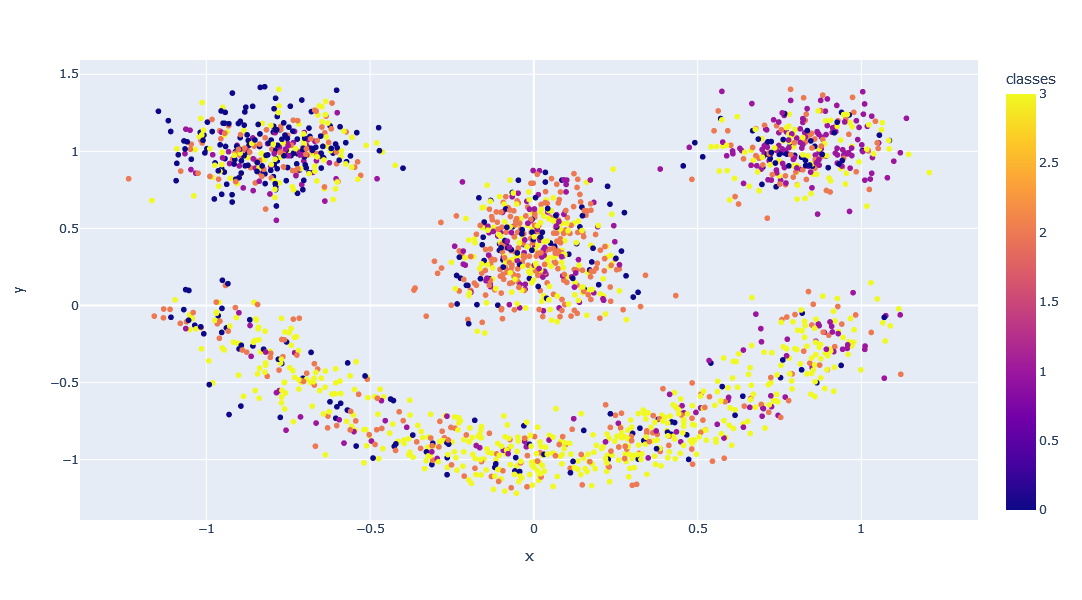

In [66]:
fig = px.scatter(gen, x = 'x', y = 'y', color = 'classes', width = 600, height = 600)
fig

In [67]:
enc = OneHotEncoder(sparse = False)
gen_enc = enc.fit_transform(gen[['classes']])
gen[['0', '1', '2', '3']] = gen_enc
gen.drop(['classes'], axis = 1, inplace = True)
gen['label'] = 0

In [68]:
X3 = pd.concat((smiley, gen))

In [69]:
gen

,x,y,0,1,2,3,label
0,-0.638205,1.120533,0.0,0.0,1.0,0.0,0
1,0.047534,0.364558,0.0,0.0,1.0,0.0,0
2,-0.013412,0.175276,1.0,0.0,0.0,0.0,0
3,-0.006574,-1.017468,0.0,0.0,0.0,1.0,0
4,0.782709,1.048921,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
1995,0.893304,-0.283916,0.0,1.0,0.0,0.0,0
1996,0.086768,-0.966999,0.0,0.0,0.0,1.0,0
1997,0.926273,1.189319,1.0,0.0,0.0,0.0,0
1998,-0.787546,1.137920,1.0,0.0,0.0,0.0,0


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X3.iloc[:, :-1], X3.iloc[:, -1], test_size = 0.3, random_state = 30025)

In [71]:
model = xgb.XGBClassifier(random_state = 1)
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [72]:
preds = xg_clf.predict(X_test)

In [73]:
np.sum(preds == y_test)/len(y_test)

0.78

In [74]:
xgbooster = xg_clf.get_booster()

In [75]:
leaves = xgbooster.predict(xgb.DMatrix(X_train), pred_leaf = True)

In [76]:
leaves.shape

(2800, 100)

In [77]:
from sklearn.neighbors import KernelDensity

In [78]:
#determining where each datapoint falls in which leaf of each tree
allocations = [{} for i in range(leaves.shape[1])]
for i in range(leaves.shape[0]):
    for j in range(leaves.shape[1]):
        if y_train.iloc[i] == 1:
            if leaves[i][j] not in allocations[j].keys():
                allocations[j][leaves[i][j]] = [i]
            else:
                allocations[j][leaves[i][j]].append(i)

In [79]:
densities = [[] for i in range(leaves.shape[1])]
probabilities = [[] for i in range(leaves.shape[1])]
multinomial = [[] for i in range(leaves.shape[1])]
simpler_densities = [[] for i in range(leaves.shape[1])]
n = sum(y_train)
for i in range(leaves.shape[1]):
    for key in allocations[i].keys():
        probabilities[i].append(len(allocations[i][key])/n)
        leaf_data = X_train.iloc[allocations[i][key]]
        leaf_size = len(leaf_data)
        multinomial[i].append([])
        densities[i].append([])
        simpler_densities[i].append(KernelDensity(kernel = 'gaussian', bandwidth = 0.1).fit(leaf_data.iloc[:, :2]))
        for j in range(4):
            index = str(j)
            if not leaf_data[leaf_data[index] == 1].empty:
                multinomial[i][-1].append(len(leaf_data[leaf_data[index] == 1])/leaf_size)
                densities[i][-1].append(KernelDensity(kernel='gaussian', bandwidth = 0.1).fit(leaf_data[leaf_data[index] == 1].iloc[:, :2]))
            else:
                multinomial[i][-1].append(0)
                densities[i][-1].append(0)

# Sampling procedure
sample_size = 2000
forest_size = 100
samples = []
samples_class = []
class_size = 4
for i in range(sample_size):
    b = np.random.choice(forest_size)
    l = np.random.choice(len(densities[b]), p = probabilities[b])
    m = np.random.choice(class_size, p = multinomial[b][l])
    sampler = densities[b][l][m]
    samples.append(sampler.sample())
    samples_class.append(m)
len(samples)

In [80]:
# alternative sampling routine
samples = []
sample_size = 2000
forest_size = 100
class_size = 4
samples_class = []
for i in range(sample_size):
    b = np.random.choice(forest_size)
    l = np.random.choice(len(densities[b]), p = probabilities[b])
    m = np.random.choice(class_size, p = multinomial[b][l])
    sampler = simpler_densities[b][l]
    samples.append(sampler.sample())
    samples_class.append(m)
len(samples)

2000

In [81]:
gen = pd.DataFrame(np.array(samples).reshape((2000, 2)))
gen['classes'] = samples_class

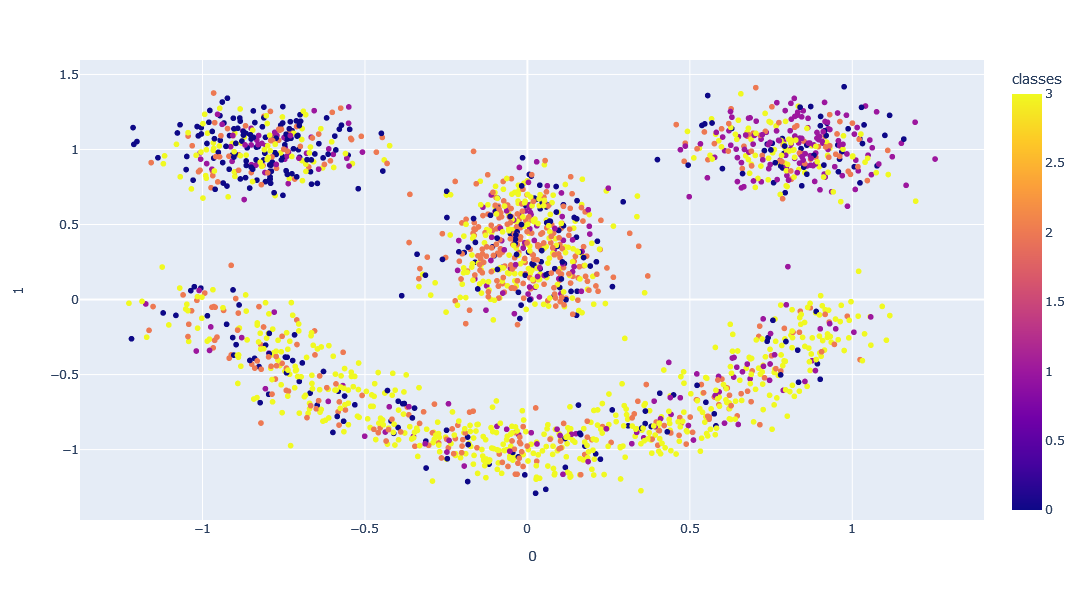

In [82]:
fig = px.scatter(gen, x = 0, y = 1, color = 'classes', width = 600, height = 600)
fig